In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tqdm.notebook import tqdm
from keras.utils import to_categorical
import gensim
import numpy as np
from keras.callbacks import callbacks
from sentence_transformers import SentenceTransformer
import re

Using TensorFlow backend.
/home/nikamanth/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/nikamanth/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/nikamanth/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/nikamanth/.local/lib/python3.7/site-packages/tenso

In [2]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [3]:
train_df = pd.read_csv('../NADI-2020_release_1.0/NADI_release/train_labeled.tsv',sep='\t')
dev_df = pd.read_csv('../NADI-2020_release_1.0/NADI_release/dev_labeled.tsv',sep='\t')

X_train_original,y_train_original = train_df["#2 tweet_content"],train_df["#3 country_label"]
X_dev_original,y_dev_original = dev_df["#2 tweet_content"],dev_df["#3 country_label"]

In [4]:
X_train_corrected_tweets = []
for tweet in tqdm(X_train_original):
    new_tweet = re.findall( '[^A-Za-z:/_.0-9\\#@,=+\(\)]+' ,tweet)
    new_tweet = " ".join(new_tweet).replace('\xa0','').replace('\u200c','').replace('\U000fe329','').replace('\u2066','').replace('\u2069','').strip()
    X_train_corrected_tweets.append(new_tweet)
    
X_dev_corrected_tweets = []
for tweet in tqdm(X_dev_original):
    new_tweet = re.findall( '[^A-Za-z:/_.0-9\\#@,=+\(\)]+' ,tweet) #[^\x00-\x19\x21-\x7F]+
    new_tweet = " ".join(new_tweet).replace('\xa0','').replace('\u200c','').replace('\U000fe329','').replace('\u2066','').replace('\u2069','').strip()
    X_dev_corrected_tweets.append(new_tweet)


In [5]:
# train_df['#2 tweet_content'] = X_train_corrected_tweets
# dev_df['#2 tweet_content'] = X_dev_corrected_tweets

In [6]:
# train_df.to_csv('../tsv/train_processed.tsv',sep='\t')
# dev_df.to_csv('../tsv/dev_processed.tsv',sep='\t')

In [7]:
list(X_train_original[20:30])

['وأستغرب كيف سمحت لنفسي ان تتابعني انت فأنا لا أتشرف بكم كشعب وضع كالسرطان في هذه الأمة',
 'قبلها بيوم أو أيام',
 '#باقي_يومين_وتدفي_جيبك ونا بعد ابي مثلكم ادفي يديني اءء اءءpic.twitter.com/YQp64JJADh',
 'بكفي فلسفة هبلة',
 'واش رايكم خاوتي فالموهبة تاعي فالرسم pic.twitter.com/tAbdNgkkrg',
 'و عليكم سالم و رحمتله و بركاته @BashiirMaxmud, @AbdullahiHamud,@IamZakariye, @AbdikaniSeed, @MrMinimo, @Ijabril, @NageeyeKhaliif, @MMGaryare, @SenatorAbshir, #Al_Shabaab,@Mohacpr, @JustAwHirsi, #yuuboos',
 'انكسار هذه الفترة ثقيل جدًا - خارت قواي -',
 'عمرها ما هتوحشني .. الحاجه الوحيده الي كانت حلوه في السنه إني عرفت ناس ومدرسين حلوين بس كدة ..https://twitter.com/ahmedlight9/status/1126489885483905024\xa0…',
 'يالي حاطه راس ابوكي ف الطين',
 'اللَّهُمَّ طهر قلبي من النفاق ، وعملي من الرياء ، ولساني من الكذب ، وعيني من الخيانة http://du3a.org']

In [8]:
X_train_corrected_tweets[20:30]

['وأستغرب كيف سمحت لنفسي ان تتابعني انت فأنا لا أتشرف بكم كشعب وضع كالسرطان في هذه الأمة',
 'قبلها بيوم أو أيام',
 'باقي يومين وتدفي جيبك ونا بعد ابي مثلكم ادفي يديني اءء اءء',
 'بكفي فلسفة هبلة',
 'واش رايكم خاوتي فالموهبة تاعي فالرسم',
 'و عليكم سالم و رحمتله و بركاته',
 'انكسار هذه الفترة ثقيل جدًا - خارت قواي -',
 'عمرها ما هتوحشني   الحاجه الوحيده الي كانت حلوه في السنه إني عرفت ناس ومدرسين حلوين بس كدة  …',
 'يالي حاطه راس ابوكي ف الطين',
 'اللَّهُمَّ طهر قلبي من النفاق ، وعملي من الرياء ، ولساني من الكذب ، وعيني من الخيانة']

In [9]:
#fasttext-arabic
from tqdm import tqdm_notebook
from nltk import word_tokenize
from pymagnitude import *


glove = Magnitude("../downloads/fasttext-arabic/fasttext-arabic.magnitude")
def avg_glove(x):
    vectors = []
    for title in tqdm_notebook(x):
        vectors.append(np.average(glove.query(word_tokenize(title)), axis = 0))
    return np.array(vectors)

X_train = avg_glove(X_train_corrected_tweets)
X_dev = avg_glove(X_dev_corrected_tweets)

/home/nikamanth/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


In [10]:
labels = {}
uni = y_train_original.unique()
for i in range(len(uni)):
    labels[uni[i]] = i

y_train_index = [labels[i] for i in y_train_original]
y_dev_index = [labels[i] for i in y_dev_original]

y_train = to_categorical(y_train_index, num_classes=21)
y_dev = to_categorical(y_dev_index, num_classes=21)

In [11]:
model = Sequential()
# model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2,return_sequences=True))
# model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2,return_sequences=False))
model.add(Dense(512, activation='relu'))
model.add(Dense(21, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',f1_m])
history = model.fit(X_train,y_train,epochs=30,validation_data=(X_dev,y_dev),
                   callbacks=[callbacks.EarlyStopping(monitor='val_f1_m', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=True)])


Train on 21000 samples, validate on 4957 samples
Epoch 1/30
21000/21000 [==============================] - 2s 101us/step - loss: 2.3525 - accuracy: 0.3133 - f1_m: 0.1822 - val_loss: 2.1838 - val_accuracy: 0.3829 - val_f1_m: 0.2372
Epoch 2/30
21000/21000 [==============================] - 2s 75us/step - loss: 2.1345 - accuracy: 0.3736 - f1_m: 0.2538 - val_loss: 2.1448 - val_accuracy: 0.3875 - val_f1_m: 0.2495
Epoch 3/30
21000/21000 [==============================] - 2s 73us/step - loss: 2.0570 - accuracy: 0.3966 - f1_m: 0.2723 - val_loss: 2.1251 - val_accuracy: 0.3958 - val_f1_m: 0.2826
Epoch 4/30
21000/21000 [==============================] - 2s 78us/step - loss: 2.0014 - accuracy: 0.4125 - f1_m: 0.2937 - val_loss: 2.1231 - val_accuracy: 0.4004 - val_f1_m: 0.3025
Epoch 5/30
21000/21000 [==============================] - 1s 71us/step - loss: 1.9573 - accuracy: 0.4244 - f1_m: 0.3104 - val_loss: 2.1123 - val_accuracy: 0.4013 - val_f1_m: 0.3037
Epoch 6/30
21000/21000 [====================

In [12]:
reverse_label_map = {value : key for (key, value) in labels.items()}
print(reverse_label_map)
pred = model.predict_classes(X_dev)
pred = [reverse_label_map[i] for i in pred]
# print(pred)
len(pred)
with open('../tsv/fasttext_result_unbal.txt','wt') as out:
    for i in pred:
        out.write(i+'\n')
with open('../tsv/gold1.txt','wt') as out2:
    for j in y_dev_original:
        out2.write(j+'\n')

{0: 'Iraq', 1: 'Egypt', 2: 'Morocco', 3: 'Libya', 4: 'United_Arab_Emirates', 5: 'Mauritania', 6: 'Saudi_Arabia', 7: 'Bahrain', 8: 'Syria', 9: 'Djibouti', 10: 'Lebanon', 11: 'Oman', 12: 'Palestine', 13: 'Algeria', 14: 'Somalia', 15: 'Jordan', 16: 'Tunisia', 17: 'Kuwait', 18: 'Yemen', 19: 'Sudan', 20: 'Qatar'}


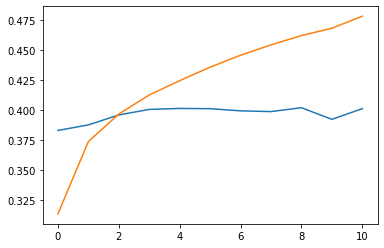

In [13]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.show()

In [80]:
y_train_original = train_df["#4 province_label"]
y_dev_original = dev_df["#4 province_label"]

In [81]:
labels = {}
uni = y_train_original.unique()
for i in range(len(uni)):
    labels[uni[i]] = i

y_train_index = [labels[i] for i in y_train_original]
y_dev_index = [labels[i] for i in y_dev_original]

y_train = to_categorical(y_train_index, num_classes=100)
y_dev = to_categorical(y_dev_index, num_classes=100)

In [42]:
model = Sequential()
# model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2,return_sequences=True))
# model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2,return_sequences=False))
model.add(Dense(512, activation='relu'))
model.add(Dense(100, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',f1_m])
history = model.fit(X_train,y_train,epochs=30,validation_data=(X_dev,y_dev),
                   callbacks=[callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=True)])

Train on 21000 samples, validate on 4957 samples
Epoch 1/30
21000/21000 [==============================] - 2s 95us/step - loss: 4.3272 - accuracy: 0.0502 - f1_m: 0.0053 - val_loss: 4.2475 - val_accuracy: 0.0438 - val_f1_m: 0.0077
Epoch 2/30
21000/21000 [==============================] - 2s 88us/step - loss: 3.9675 - accuracy: 0.0972 - f1_m: 0.0134 - val_loss: 4.1706 - val_accuracy: 0.0510 - val_f1_m: 0.0089
Epoch 3/30
21000/21000 [==============================] - 2s 91us/step - loss: 3.8140 - accuracy: 0.1209 - f1_m: 0.0178 - val_loss: 4.1648 - val_accuracy: 0.0508 - val_f1_m: 0.0104
Epoch 4/30
21000/21000 [==============================] - 2s 89us/step - loss: 3.7125 - accuracy: 0.1377 - f1_m: 0.0249 - val_loss: 4.1593 - val_accuracy: 0.0522 - val_f1_m: 0.0156
Epoch 5/30
21000/21000 [==============================] - 2s 89us/step - loss: 3.6285 - accuracy: 0.1556 - f1_m: 0.0314 - val_loss: 4.1839 - val_accuracy: 0.0553 - val_f1_m: 0.0171
Epoch 6/30
21000/21000 [======================

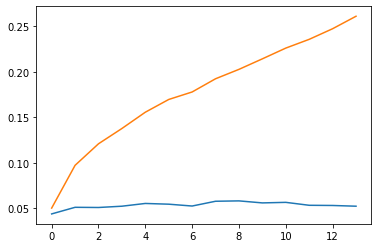

In [45]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.show()

In [68]:
# stop word removal

In [51]:
fil = open('../downloads/stopwords/list.txt')
sw = fil.read().split('\n')

In [52]:
sw

['،',
 'ء',
 'ءَ',
 'آ',
 'آب',
 'آذار',
 'آض',
 'آل',
 'آمينَ',
 'آناء',
 'آنفا',
 'آه',
 'آهاً',
 'آهٍ',
 'آهِ',
 'أ',
 'أبدا',
 'أبريل',
 'أبو',
 'أبٌ',
 'أجل',
 'أجمع',
 'أحد',
 'أخبر',
 'أخذ',
 'أخو',
 'أخٌ',
 'أربع',
 'أربعاء',
 'أربعة',
 'أربعمئة',
 'أربعمائة',
 'أرى',
 'أسكن',
 'أصبح',
 'أصلا',
 'أضحى',
 'أطعم',
 'أعطى',
 'أعلم',
 'أغسطس',
 'أفريل',
 'أفعل به',
 'أفٍّ',
 'أقبل',
 'أكتوبر',
 'أل',
 'ألا',
 'ألف',
 'ألفى',
 'أم',
 'أما',
 'أمام',
 'أمامك',
 'أمامكَ',
 'أمد',
 'أمس',
 'أمسى',
 'أمّا',
 'أن',
 'أنا',
 'أنبأ',
 'أنت',
 'أنتم',
 'أنتما',
 'أنتن',
 'أنتِ',
 'أنشأ',
 'أنه',
 'أنًّ',
 'أنّى',
 'أهلا',
 'أو',
 'أوت',
 'أوشك',
 'أول',
 'أولئك',
 'أولاء',
 'أولالك',
 'أوّهْ',
 'أى',
 'أي',
 'أيا',
 'أيار',
 'أيضا',
 'أيلول',
 'أين',
 'أيّ',
 'أيّان',
 'أُفٍّ',
 'ؤ',
 'إحدى',
 'إذ',
 'إذا',
 'إذاً',
 'إذما',
 'إذن',
 'إزاء',
 'إلى',
 'إلي',
 'إليكم',
 'إليكما',
 'إليكنّ',
 'إليكَ',
 'إلَيْكَ',
 'إلّا',
 'إمّا',
 'إن',
 'إنَّ',
 'إى',
 'إياك',
 'إياكم',
 'إياكما',
 'إياكن',


In [61]:
X_train_corrected_tweets = []
for tweet in tqdm(X_train_original):
    new_tweet = re.findall( '[^A-Za-z:/_.0-9\\#@,=+\(\)]+' ,tweet)
    new_tweet = " ".join(new_tweet).replace('\xa0','').replace('\u200c','').replace('\U000fe329','').replace('\u2066','').replace('\u2069','').strip()
    for word in sw:
        if word in new_tweet:
            new_tweet.replace(word+' ','')
    X_train_corrected_tweets.append(new_tweet)
    
X_dev_corrected_tweets = []
for tweet in tqdm(X_dev_original):
    new_tweet = re.findall( '[^A-Za-z:/_.0-9\\#@,=+\(\)]+' ,tweet) #[^\x00-\x19\x21-\x7F]+
    new_tweet = " ".join(new_tweet).replace('\xa0','').replace('\u200c','').replace('\U000fe329','').replace('\u2066','').replace('\u2069','').strip()
    for word in sw:
        if word in new_tweet:
            new_tweet.replace(word+' ','')
    X_dev_corrected_tweets.append(new_tweet)


In [62]:
#fasttext-arabic
from tqdm import tqdm_notebook
from nltk import word_tokenize
from pymagnitude import *


glove = Magnitude("../downloads/fasttext-arabic/fasttext-arabic.magnitude")
def avg_glove(x):
    vectors = []
    for title in tqdm_notebook(x):
        vectors.append(np.average(glove.query(word_tokenize(title)), axis = 0))
    return np.array(vectors)

X_train = avg_glove(X_train_corrected_tweets)
X_dev = avg_glove(X_dev_corrected_tweets)

/home/nikamanth/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


In [79]:
y_train_original = train_df["#3 country_label"]
y_dev_original = dev_df["#3 country_label"]

In [65]:
labels = {}
uni = y_train_original.unique()
for i in range(len(uni)):
    labels[uni[i]] = i

y_train_index = [labels[i] for i in y_train_original]
y_dev_index = [labels[i] for i in y_dev_original]

y_train = to_categorical(y_train_index, num_classes=21)
y_dev = to_categorical(y_dev_index, num_classes=21)

In [67]:
model = Sequential()
# model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2,return_sequences=True))
# model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2,return_sequences=False))
model.add(Dense(512, activation='relu'))
model.add(Dense(21, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',f1_m])
history = model.fit(X_train,y_train,epochs=30,validation_data=(X_dev,y_dev),
                   callbacks=[callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=True)])

Train on 21000 samples, validate on 4957 samples
Epoch 1/30
21000/21000 [==============================] - 2s 85us/step - loss: 2.3525 - accuracy: 0.3115 - f1_m: 0.1811 - val_loss: 2.1835 - val_accuracy: 0.3807 - val_f1_m: 0.2368
Epoch 2/30
21000/21000 [==============================] - 2s 77us/step - loss: 2.1297 - accuracy: 0.3742 - f1_m: 0.2567 - val_loss: 2.1437 - val_accuracy: 0.3940 - val_f1_m: 0.2631
Epoch 3/30
21000/21000 [==============================] - 2s 78us/step - loss: 2.0555 - accuracy: 0.3974 - f1_m: 0.2756 - val_loss: 2.1253 - val_accuracy: 0.3898 - val_f1_m: 0.2718
Epoch 4/30
21000/21000 [==============================] - 2s 78us/step - loss: 2.0027 - accuracy: 0.4125 - f1_m: 0.2916 - val_loss: 2.1209 - val_accuracy: 0.3960 - val_f1_m: 0.2785
Epoch 5/30
21000/21000 [==============================] - 2s 86us/step - loss: 1.9622 - accuracy: 0.4231 - f1_m: 0.3091 - val_loss: 2.1191 - val_accuracy: 0.4010 - val_f1_m: 0.3108
Epoch 6/30
21000/21000 [======================